In [4]:
"""
    Reproduce Figure 2.
"""

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import os

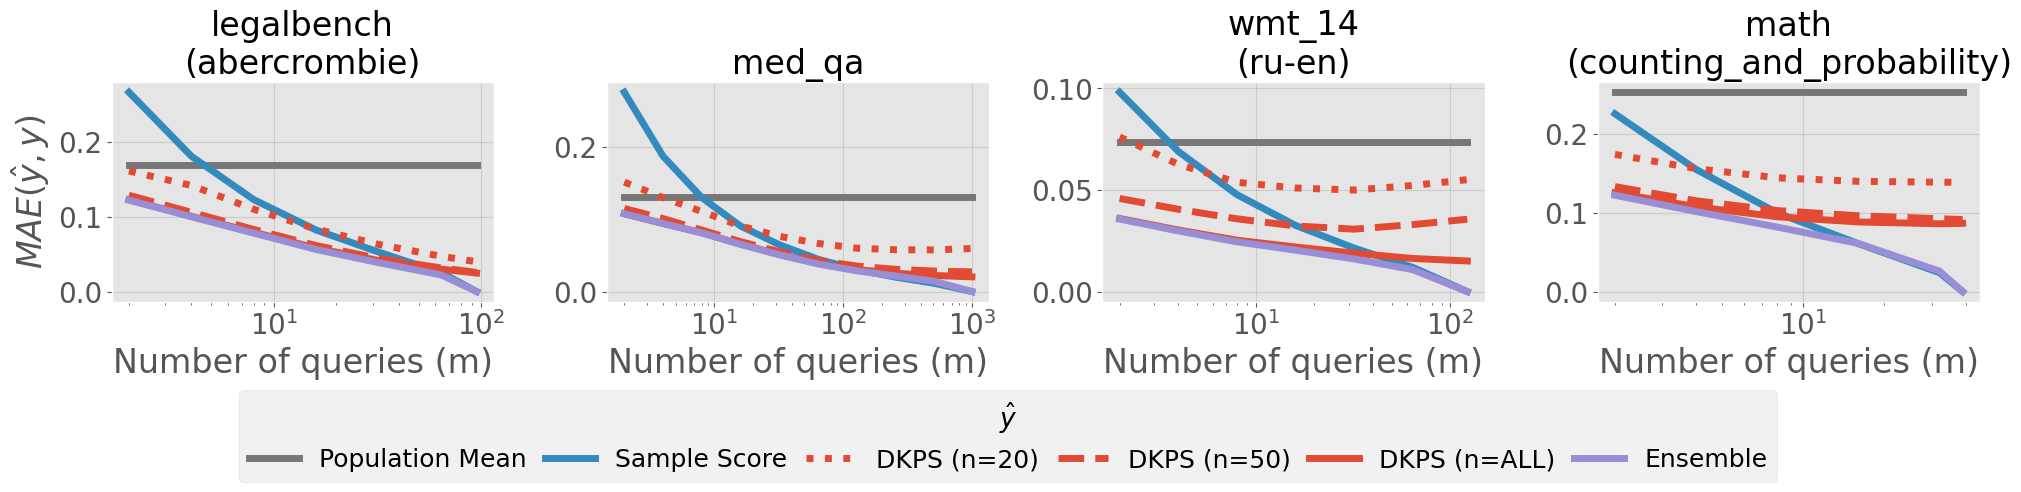

In [14]:
plt.style.use('ggplot')

_cols = [
    {
        "colname"   : "e_null",
        "label"     : "Population Mean",
        "c"         : "black",
        "linestyle" : "-",
        "plots"     : [0, 1],
    },
    {
        "colname"   : "e_sample",
        "label"     : "Sample Mean",
        "c"         : "green",
        "linestyle" : "-",
        "plots"     : [0, 1],
    },
    {
        "colname"   : "e_lr_dkps__n_components_cmds=8__n_models=20",
        "label"     : "DKPS(d=8, n_models=20)",
        "c"         : "red",
        "linestyle" : ":",
        "plots"     : [0],
    },
    {
        "colname"   : "e_lr_dkps__n_components_cmds=8__n_models=50",
        "label"     : "DKPS(d=8, n_models=50)",
        "c"         : "red",
        "linestyle" : "--",
        "plots"     : [0],
    },
    {
        "colname"   : "e_lr_dkps__n_components_cmds=8__n_models=ALL",
        "label"     : "DKPS(d=8, n_models=ALL)",
        "c"         : "red",
        "linestyle" : "-",
        "plots"     : [0, 1],
    },
    {
        "colname"   : "e_interp",
        "label"     : "interp(e_sample+e_lr_dkps)",
        "c"         : "blue",
        "linestyle" : "-",
        "plots"     : [1],
    },
]

dataset = 'math:subject=intermediate_algebra'
embed_model = 'embed-google'
score_col = 'score'
results_dir = f'/home/paperspace/projects/dkps/examples/helm/results/'

# tsv_path = Path(results_dir) / dataset.replace(':', '-') / score_col / '1024' / 'dkps' / 'results.tsv'

fontsize=24
labelsize=20

keep_list = ['legalbench-subset=abercrombie', 'med_qa', 'wmt_14-language_pair=ru-en', 'math-subject=counting_and_probability']
method_label_dict = {
    'Sample Mean': 'Sample Score',
    'Population Mean': 'Population Mean',
    'DKPS(d=8, n_models=20)': 'DKPS (n=20)',
    'DKPS(d=8, n_models=50)': 'DKPS (n=50)',
    'DKPS(d=8, n_models=ALL)': 'DKPS (n=ALL)',
    'interp(e_sample+e_lr_dkps)': 'Ensemble'
}

color_dict = {
    'Sample Mean': list(plt.rcParams['axes.prop_cycle'])[1]['color'],
    'Population Mean': list(plt.rcParams['axes.prop_cycle'])[3]['color'],
    'DKPS(d=8, n_models=20)': list(plt.rcParams['axes.prop_cycle'])[0]['color'],
    'DKPS(d=8, n_models=50)': list(plt.rcParams['axes.prop_cycle'])[0]['color'],
    'DKPS(d=8, n_models=ALL)': list(plt.rcParams['axes.prop_cycle'])[0]['color'],
    'interp(e_sample+e_lr_dkps)': list(plt.rcParams['axes.prop_cycle'])[2]['color']
}

embedding_dict = {
    'legalbench-subset=abercrombie': 'embed-local-onehot', 
    'med_qa': 'embed-local-onehot',
    'wmt_14-language_pair=ru-en': 'embed-google',
    'math-subject=counting_and_probability': 'embed-google'
}

score_dict = {
    'legalbench-subset=abercrombie': 'score', 
    'med_qa': 'score',
    'wmt_14-language_pair=ru-en': 'meteor',
    'math-subject=counting_and_probability': 'score'
}

result_dict = {}

fig, axs = plt.subplots(1,4, figsize=(20,4))

for embed_model in ['embed-google', 'embed-local-onehot']:
    _results_dir = results_dir + embed_model
    for file in os.listdir(_results_dir):
        if file not in keep_list:
            continue 
    
        score_col =score_dict[file]
    
        tsv_path = Path(_results_dir) / file / score_col / '1024' / 'dkps' / 'results.tsv'
        
        # _keep = False
        for i, keep in enumerate(keep_list):
            if keep in file:
                _keep = True
                break
    
        task = file.split(':')[0]
        if 'med_qa' in task:
            task = 'med_qa'
            subtask = task
        else:
            subtask = file.split('=')[1]
            subtask  =subtask.split('-meteor')[0]
            subtask  =subtask.split('-score')[0]
    
        if task not in result_dict:
            result_dict[task] = {}
    
        result_dict[task][subtask] = {}
    
        if not _keep:
            continue
        
    
        df_res = pd.read_csv(tsv_path, sep='\t')
        model_names  = df_res.target_model.unique()
        n_replicates = df_res.seed.nunique()
        
        # alias the run with all models
        df_res['p_lr_dkps8'] = df_res['p_lr_dkps__n_components_cmds=8__n_models=ALL']
        
        # compute interpolation
        max_samples        = df_res.n_samples.max()
        df_res['p_interp'] = (df_res.n_samples * df_res.p_sample + (max_samples - df_res.n_samples) * df_res.p_lr_dkps8) / max_samples
        df_res['e_interp'] = np.abs(df_res.p_interp - df_res.y_act)
    
        dkps_cols = [c for c in df_res.columns if 'p_' in c]
        for c in dkps_cols:
            df_res[c] = df_res[c].clip(0, 1)
    
        for c in dkps_cols:
            df_res[c.replace('p_', 'e_')] = np.abs(df_res[c] - df_res.y_act)
        
        if any([xx in dataset for xx in ['med_qa', 'legalbench']]):
            df_res = df_res[df_res.n_samples > 2]
    
    
        df_avg = df_res.groupby(['mode', 'n_samples']).agg({
            'y_act' : lambda x: np.mean(x),
            **{c['colname']: lambda x: np.mean(x) for c in _cols},
        }).reset_index()
    
        ax = axs[i]
        
        # 0th version
        for c in _cols:
            # if 1 not in c['plots']: continue
            method_label = method_label_dict[c['label']]
            if 'm/M' in method_label:
                color='brown'
            else:
                color=c['c']
            color=color_dict[c['label']]
            ax.plot(df_avg.n_samples, df_avg[c['colname']], label=method_label, c=color, linestyle=c['linestyle'], lw=5)
            n_sample_list = list(df_avg.n_samples)
            average_list = list(df_avg[c['colname']])
            result_dict[task][subtask][method_label] = {n_sample: avg for (n_sample, avg) in zip(n_sample_list, average_list)}
        
        # _ = ax.legend()
        ax.grid('both', alpha=0.25, c='gray')
        ax.set_xscale('log')
        ax.set_xlabel('Number of queries (m)', fontsize=fontsize)
        if 'wmt' in file:
            title = 'wmt_14\n' + '(ru-en)'
        else:
            title=file.replace('-', '\n')
            if '=' in title:
                title = title.split('\n')[0] + '\n' + f'({title.split('\n')[-1].split('=')[-1]})'
        ax.set_title(f'{title}', fontsize=fontsize)
        ax.tick_params(labelsize=labelsize)


axs[0].set_ylabel(r'$MAE(\hat{y}, y)$', fontsize=fontsize)
plt.tight_layout()
axs[0].legend(loc='lower left', columnspacing=0.75, bbox_to_anchor=(0.3,-0.88), ncols=6, fontsize=labelsize-2, title=r'$\hat{y}$', title_fontsize=labelsize-1, framealpha=0.5)

plt.savefig('figures/fig2.pdf', bbox_inches='tight')